In [112]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### vgg feature analysis 

In [113]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [114]:
# retrieve sketch paths
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
# path_to_sketches = '../sketches'
path_to_sketches = 'sketches'
sketch_paths = sorted(list_files(path_to_sketches))

In [115]:
## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths))

Number of sketch paths = 569


## extract features

**Dec 28 2017:** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png' --layer_ind=6 --cohort='adult'`

In [116]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))

In [117]:
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']            
    F = np.load('./features/FEATURES_{}_{}.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('./features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

## load in kid features
KF, KM = load_features('kid',6)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print np.shape(KF)

(387, 4096)


### quick classification test

In [119]:
#### Quick classification test
FEAT = KF
LABELS = KM.label.values
AGES = KM.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
# clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 0
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=3)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.319587628866


In [120]:
# ## see how recognizability changes with age?
# scores = []
# num_samples = []
# age_range = np.arange(4,11)


# # width of moving window in # of trials    
# window_size = 2
# lb = int(min(_Y.age.values))
# ub = int(max(_Y.age.values))
# num_windows = ub-lb-window_size+2 ##     

# for n in np.arange(num_windows):
#     start = lb + n
#     end = lb + n + window_size
#     ind = _Y.index[(_Y['age'] >= start) & (_Y['age'] < end)]
#     meta = _Y.loc[ind]
#     subFeat = _Features[ind.tolist()]

#     FEAT = subFeat
#     LABELS = meta.label.values

#     # single train/test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         FEAT, LABELS, test_size=0.5, random_state=0)
# #     clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#     clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
#     print '{}-{}y'.format(start, end-1), len(LABELS),clf.score(X_test, y_test)
#     num_samples.append(len(LABELS))
#     scores.append(clf.score(X_test, y_test))
    

NameError: name '_Y' is not defined

In [122]:
print "3 yr olds made %s drawings" % (sum(KM['age'] == 3 ))
print "4 yr olds made %s drawings" % (sum(KM['age'] == 4 ))
print "5 yr olds made %s drawings" % (sum(KM['age'] == 5 ))
print "6 yr olds made %s drawings" % (sum(KM['age'] == 6 ))
print "7 yr olds made %s drawings" % (sum(KM['age'] == 7 ))
print "8 yr olds made %s drawings" % (sum(KM['age'] == 8 ))
print "9 yr olds made %s drawings" % (sum(KM['age'] == 9 ))
print "10 yr olds made %s drawings" % (sum(KM['age'] == 10 ))


3 yr olds made 6 drawings
4 yr olds made 44 drawings
5 yr olds made 67 drawings
6 yr olds made 60 drawings
7 yr olds made 62 drawings
8 yr olds made 87 drawings
9 yr olds made 8 drawings
10 yr olds made 53 drawings


In [123]:
## add additional column that coarse grains age
def coarse_grain_age(row):
    if row['age'] > 6:
        val = 'older'
    elif row['age'] <= 6:
        val = 'younger'
    return val

KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)


print "younger kids made %s drawings" % (sum(KM['coarse_age'] == 'younger' ))
print "older kids made %s drawings" % (sum(KM['coarse_age'] == 'older' ))

younger kids made 177 drawings
older kids made 210 drawings


In [126]:
## subset labels that have at least some drawings of them from each age category
younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
older_labels = KM[KM['coarse_age'] == 'older']['label'].values

## list of labels that are in both younger and older age categories
common_labels = list(np.intersect1d(younger_labels,older_labels))

def subset_common_labels(F,M, common_labels):
    '''
    only include labels that are common to younger and older cohort
    '''
    _F = F[M['label'].isin(common_labels),:]
    _M = M[M['label'].isin(common_labels)]
    return _F, _M

KF, KM = subset_common_labels(KF, KM, common_labels)
KM = KM.reset_index(drop=True)

In [127]:
np.shape(common_labels)
for l in common_labels:
    print "%s -- %d drawings" % (l,sum(KM['label'] == l ))

airplane -- 5 drawings
apple -- 4 drawings
banana -- 17 drawings
bear -- 8 drawings
bed -- 4 drawings
bike -- 5 drawings
bird -- 8 drawings
boat -- 18 drawings
bus -- 7 drawings
car -- 18 drawings
carrot -- 17 drawings
cat -- 16 drawings
chair -- 20 drawings
cookie -- 5 drawings
couch -- 16 drawings
cup -- 17 drawings
dog -- 4 drawings
door -- 2 drawings
duck -- 2 drawings
fish -- 8 drawings
flower -- 20 drawings
foot -- 16 drawings
fork -- 4 drawings
frog -- 15 drawings
hat -- 6 drawings
ice cream -- 17 drawings
keys -- 5 drawings
phone -- 18 drawings
piano -- 5 drawings
rabbit -- 21 drawings
shark -- 4 drawings
sheep -- 5 drawings
shoe -- 18 drawings
table -- 6 drawings
train -- 23 drawings


In [128]:
younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
older_labels = KM[KM['coarse_age'] == 'older']['label'].values
thres=4
high_number_labels=[]
for label in common_labels:
    if sum(older_labels == label)>thres:
        if sum(younger_labels == label)>thres:
            print label
            high_number_labels.append(label)

KFS, KMS = subset_common_labels(KF, KM, high_number_labels)
KMS = KMS.reset_index(drop=True)

banana
boat
car
carrot
chair
couch
cup
foot
frog
ice cream
phone
rabbit
shoe
train


In [47]:
KMS

,label,age,session,coarse_age
0,banana,4,E1c_1510691847400,younger
1,banana,5,E1c_1510253748384,younger
2,banana,5,E1c_1510786719020,younger
3,banana,5,E1c_1511301440421,younger
4,banana,6,E1c_1510782034963,younger
5,banana,6,E1c_1511292022297,younger
6,banana,6,E1c_1511292286803,younger
7,banana,6,E1c_1511293092153,younger
8,banana,7,E1c_1511301009480,older
9,banana,8,E1c_1510254933095,older


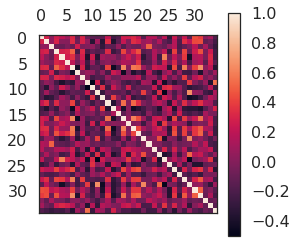

In [68]:
## plot RDM collapsing across all ages
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = KM.label.values
means = get_class_means(KF, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()

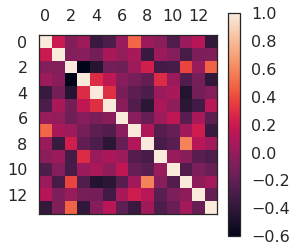

In [129]:
## plot RDM collapsing across all ages -- subset
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = KMS.label.values
means = get_class_means(KFS, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()

(35, 35)


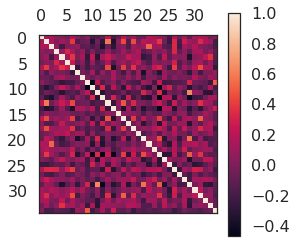

In [70]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'older']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
print(CORRMAT.shape)
plt.matshow(CORRMAT)
plt.colorbar()
olderKidsFull = CORRMAT

(14, 14)


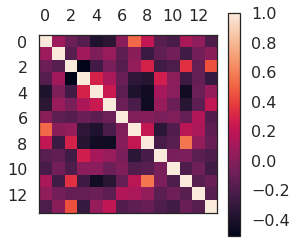

In [71]:
## get RDM for older kids (7,8,9,10) -- subset
ind = KMS.index[KMS['coarse_age'] == 'older']
meta = KMS.loc[ind]
feat = KFS[ind.tolist()]
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
print(CORRMAT.shape)
plt.matshow(CORRMAT)
plt.colorbar()
olderKidsSubset=CORRMAT

(35, 35)


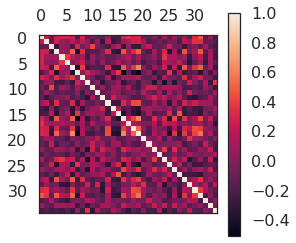

In [72]:
## get RDM for young kids (3,4,5,6)
ind = KM.index[KM['coarse_age'] == 'younger']
subY = KM.loc[ind]
subFeat = KF[ind.tolist()]

meta = subY
feat = subFeat
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
print(CORRMAT.shape)
plt.matshow(CORRMAT)
plt.colorbar()
youngerKidsFull = CORRMAT

(14, 14)


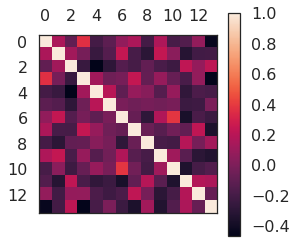

In [73]:
## get RDM for young kids (3,4,5,6) - subset
ind = KMS.index[KMS['coarse_age'] == 'younger']
subY = KMS.loc[ind]
subFeat = KFS[ind.tolist()]

meta = subY
feat = subFeat
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
print(CORRMAT.shape)
plt.matshow(CORRMAT)
plt.colorbar()
youngerKidsSubset=CORRMAT

In [74]:
import scipy.stats as stats
stats.spearmanr(np.ravel(youngerKidsFull),np.ravel(olderKidsFull))

SpearmanrResult(correlation=0.50616302716794281, pvalue=1.1166425470723263e-80)

In [75]:
stats.spearmanr(np.ravel(youngerKidsSubset),np.ravel(olderKidsSubset))

SpearmanrResult(correlation=0.48088799259607601, pvalue=9.7574063753580303e-13)

### Extract adult drawing features

In [130]:
## load in adult features
AF, AM = load_features('adult',6)
AF, AM = remove_practice_trials(AF, AM)
AM = AM.reset_index(drop=True)
print np.shape(AF)

(38000, 4096)


In [131]:
## set up lookup table to cover discrepancies in category label assignments
lookup = dict(zip(common_labels,common_labels))
lookup['bike'] = 'bicycle'

In [132]:
AF, AM = subset_common_labels(AF, AM, [lookup[i] for i in common_labels])
AM = AM.reset_index(drop=True)

AFS, AMS = subset_common_labels(AF, AM, [lookup[i] for i in high_number_labels])
AMS = AMS.reset_index(drop=True)

In [133]:
high_number_labels

['banana',
 'boat',
 'car',
 'carrot',
 'chair',
 'couch',
 'cup',
 'foot',
 'frog',
 'ice cream',
 'phone',
 'rabbit',
 'shoe',
 'train']

(14, 14)


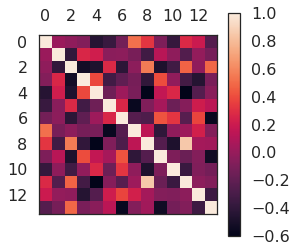

In [138]:
## sorted adult RDMs
# labels = AM.label.values
# adult_means = get_class_means(AF, labels)
# ordered_means = adult_means[sort_inds,:]
# sns.set_style('white')
# CORRMAT = np.corrcoef(ordered_means)

labels = AMS.label.values
adult_means = get_class_means(AFS, labels)
sns.set_style('white')
CORRMAT = np.corrcoef(adult_means)
print(CORRMAT.shape)
plt.matshow(CORRMAT)
plt.colorbar()
adultsSubset=CORRMAT

## retrieve alpha sorted labels from meta
# _labels = np.unique(AM.label.values)
_labels = np.unique(AMS.label.values)

In [135]:
def flatten(x):
    return [item for sublist in x for item in sublist]

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

af = AffinityPropagation(damping=0.5).fit(adult_means)

In [136]:
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

Clusters
['carrot' 'chair']
['banana' 'car' 'frog' 'rabbit']
['phone']
['boat' 'couch' 'cup' 'foot' 'ice cream' 'shoe']
['train']


In [141]:
stats.spearmanr(np.ravel(adultsSubset),np.ravel(olderKidsSubset))
stats.spearmanr(np.ravel(adultsSubset),np.ravel(youngerKidsSubset))

SpearmanrResult(correlation=0.53372420381764951, pvalue=7.9544443203310691e-16)

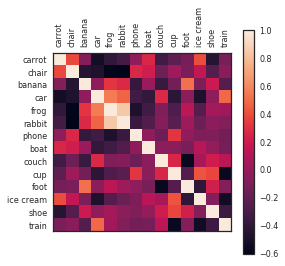

In [165]:
sns.set_context('paper')
fig = plt.figure(figsize=(24,24))
CORRMAT = np.corrcoef(adult_means[sort_inds,:])
plt.matshow(CORRMAT)

plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
plt.yticks(range(len(ordered_objs)), ordered_objs); 
plt.colorbar()
for tick in pylab.gca().xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')
    tick[0].tick1On = False
    tick[0].tick2On = False
for tick in pylab.gca().yaxis.iter_ticks():
    tick[0].tick1On = False
    tick[0].tick2On = False  
ARDM = CORRMAT

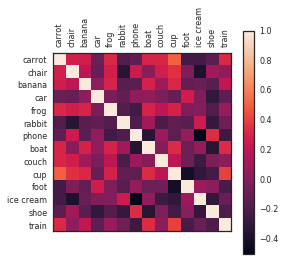

In [166]:
## plot sorted kid RDM collapsing across all ages
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = KM.label.values
kid_means = get_class_means(KF, labels)
ordered_means = kid_means[sort_inds,:]
CORRMAT = np.corrcoef(ordered_means)
plt.matshow(CORRMAT)
plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
plt.yticks(range(len(ordered_objs)), ordered_objs); 
plt.colorbar()
for tick in pylab.gca().xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')
    tick[0].tick1On = False
    tick[0].tick2On = False
for tick in pylab.gca().yaxis.iter_ticks():
    tick[0].tick1On = False
    tick[0].tick2On = False  
KRDM = CORRMAT

In [159]:
import scipy.stats as stats
stats.spearmanr(np.ravel(ARDM),np.ravel(KRDM))

SpearmanrResult(correlation=0.4090767761648465, pvalue=1.2863875329655047e-50)

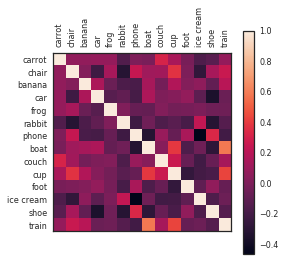

In [160]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'older']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
older_means = get_class_means(feat, labels)
ordered_means = older_means[sort_inds,:]
CORRMAT = np.corrcoef(ordered_means)
plt.matshow(CORRMAT)
plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
plt.yticks(range(len(ordered_objs)), ordered_objs); 
plt.colorbar()
for tick in pylab.gca().xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')
    tick[0].tick1On = False
    tick[0].tick2On = False
for tick in pylab.gca().yaxis.iter_ticks():
    tick[0].tick1On = False
    tick[0].tick2On = False  
ORDM = CORRMAT

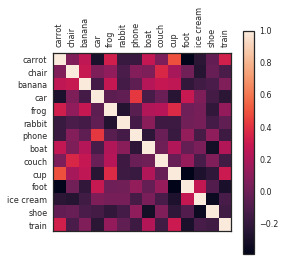

In [164]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'younger']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
younger_means = get_class_means(feat, labels)
ordered_means = younger_means[sort_inds,:]
CORRMAT = np.corrcoef(ordered_means)
plt.matshow(CORRMAT)
plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
plt.yticks(range(len(ordered_objs)), ordered_objs); 
plt.colorbar()
for tick in pylab.gca().xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')
    tick[0].tick1On = False
    tick[0].tick2On = False
for tick in pylab.gca().yaxis.iter_ticks():
    tick[0].tick1On = False
    tick[0].tick2On = False  
YRDM = CORRMAT